Found 48 files in the directory.


How many files do you want to label? (Max 48):  48


Labeling file 1/48: RGB_2022-07-06.jpg


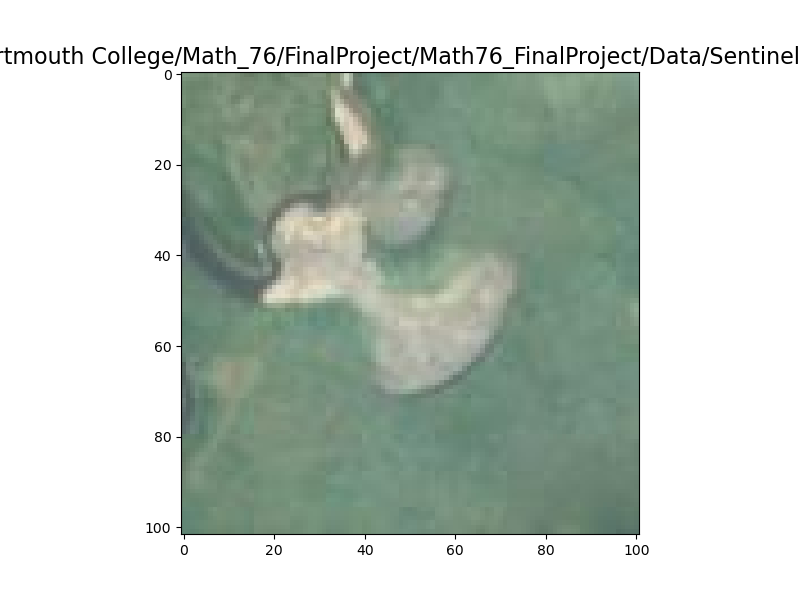

Labeling file 2/48: RGB_2022-09-02.jpg


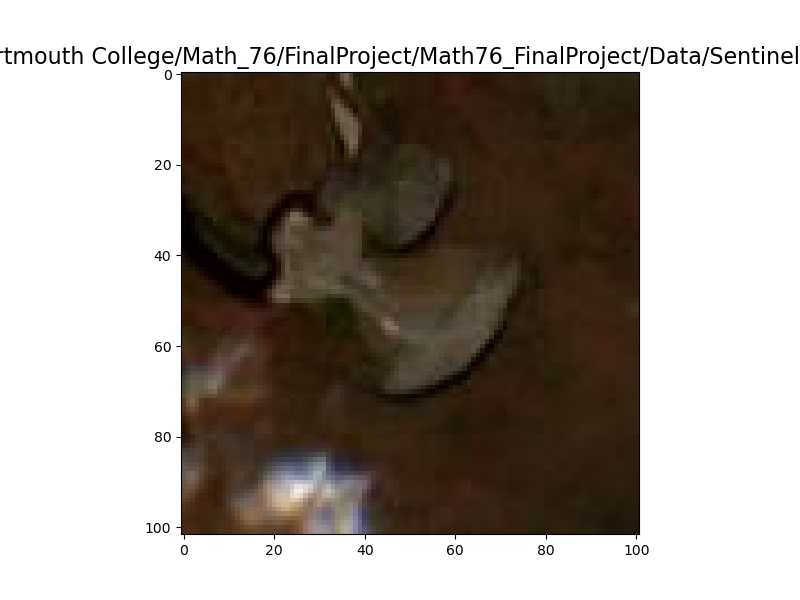

Labeling file 3/48: RGB_2020-09-19.jpg


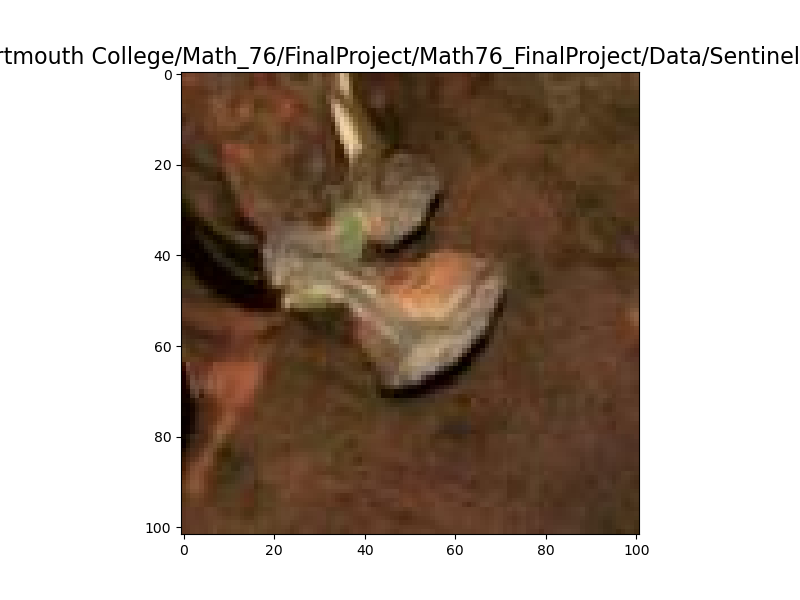

Labeling file 4/48: RGB_2022-06-14.jpg


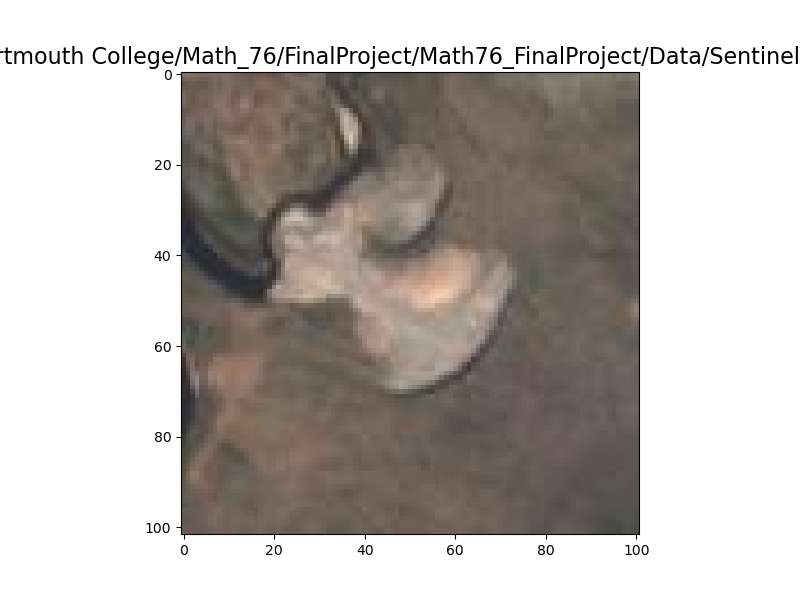

Labeling file 5/48: RGB_2024-06-10.jpg


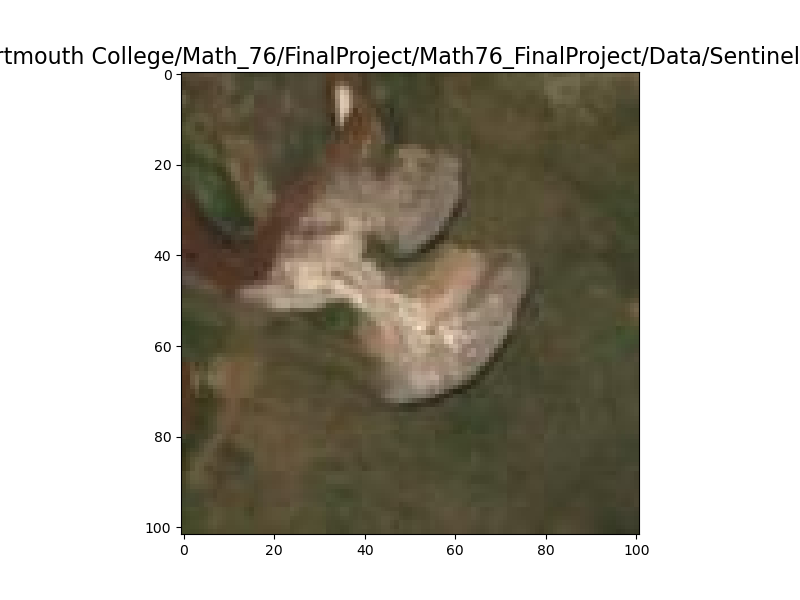

Labeling file 6/48: RGB_2023-06-24.jpg


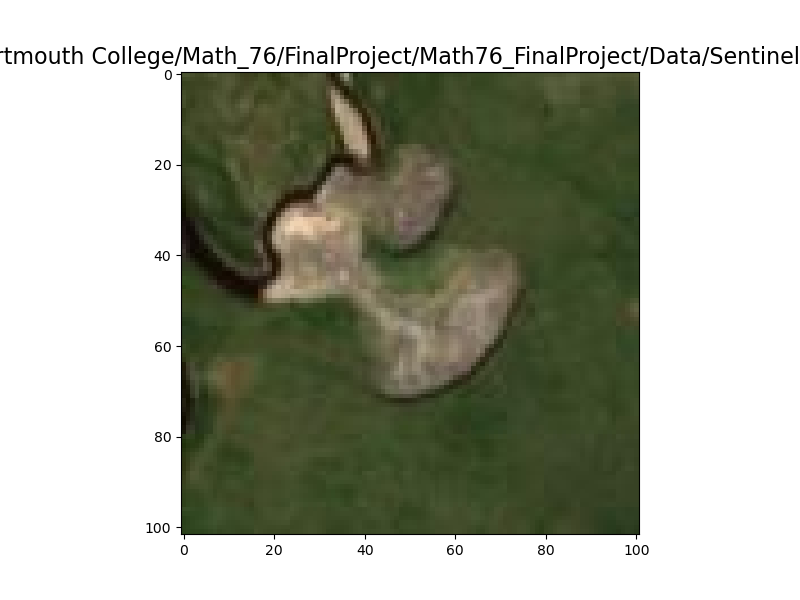

Labeling file 7/48: RGB_2023-07-04.jpg


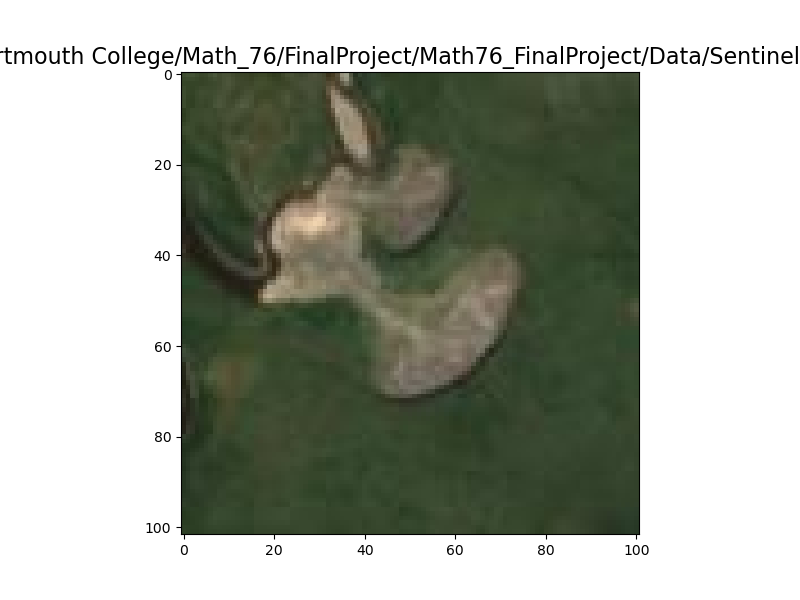

Labeling file 8/48: RGB_2020-06-18.jpg


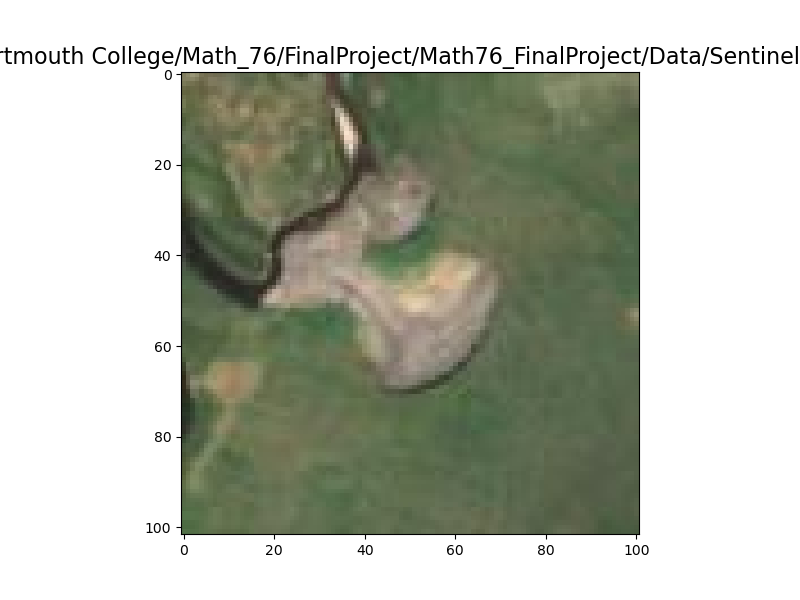

Labeling file 9/48: RGB_2019-09-28.jpg


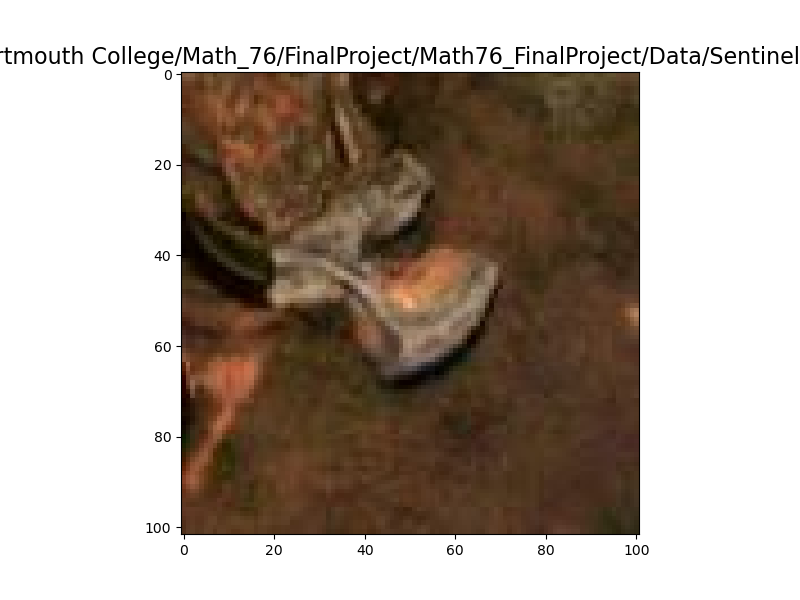

Labeling file 10/48: RGB_2023-07-29.jpg


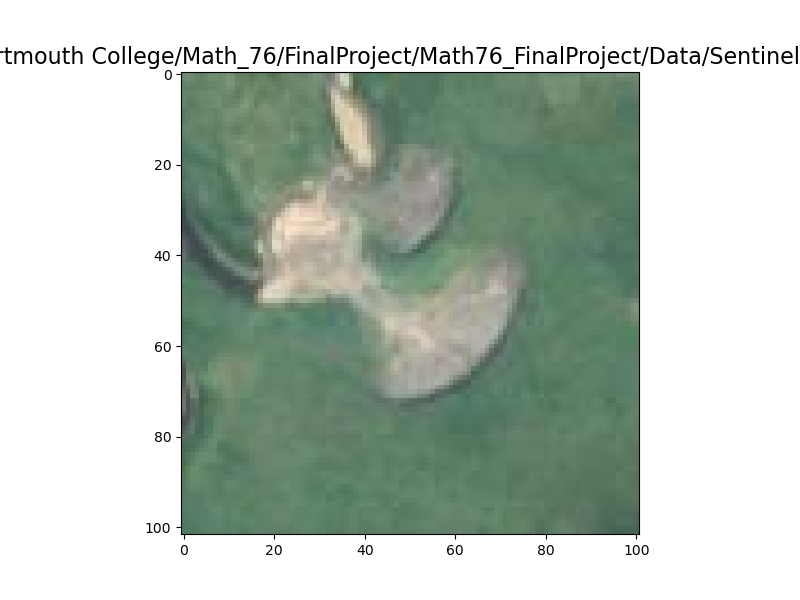

Labeling file 11/48: RGB_2023-08-08.jpg


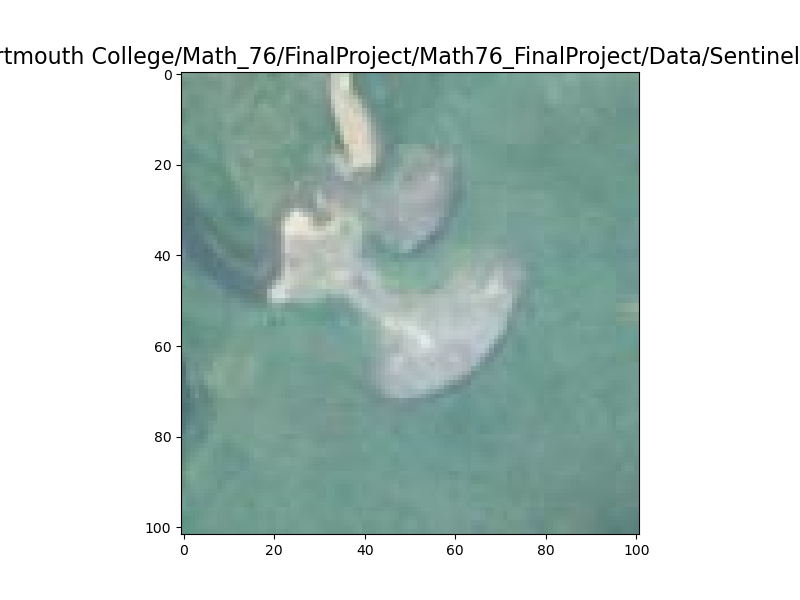

Labeling file 12/48: RGB_2019-06-17.jpg


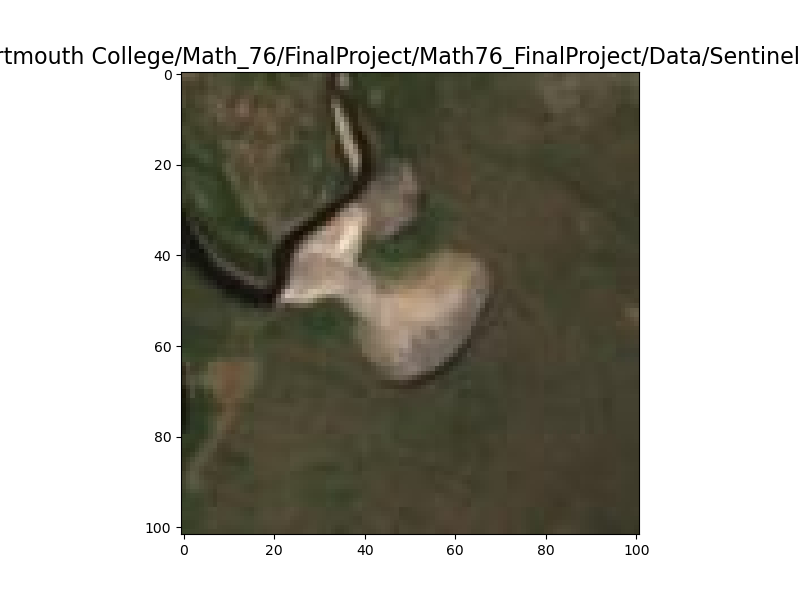

Labeling file 13/48: RGB_2021-06-06.jpg


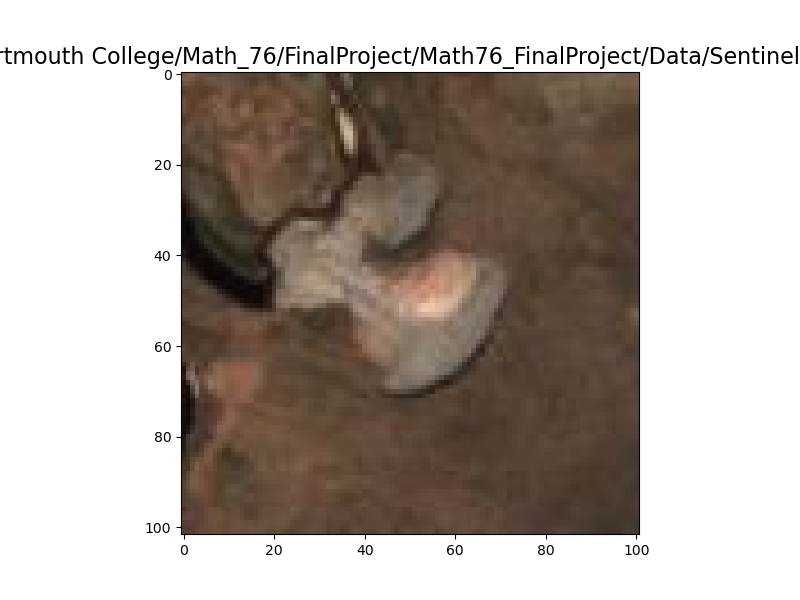

Labeling file 14/48: RGB_2019-06-10.jpg


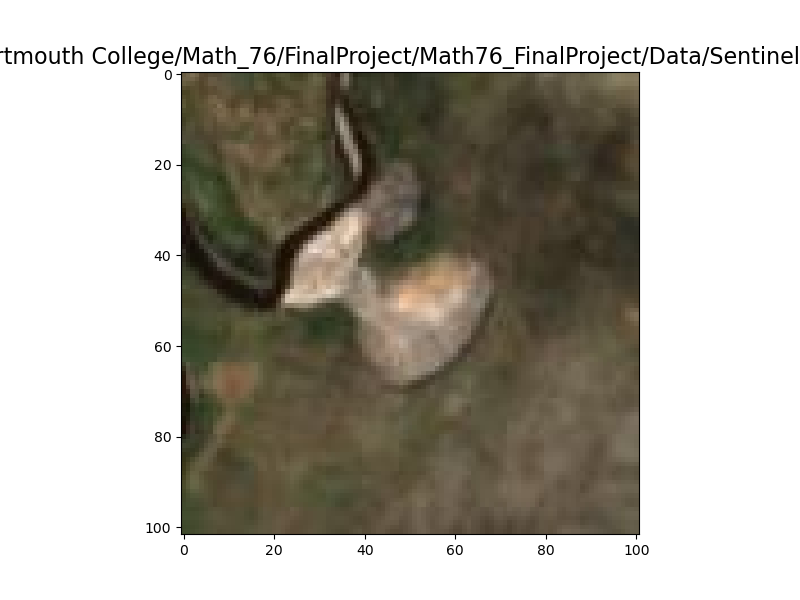

Labeling file 15/48: RGB_2022-08-30.jpg


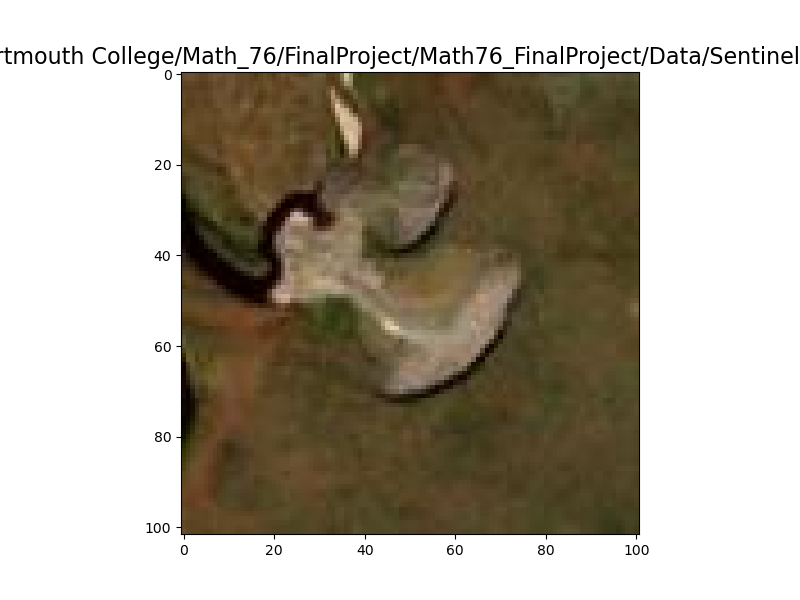

Labeling file 16/48: RGB_2020-06-03.jpg


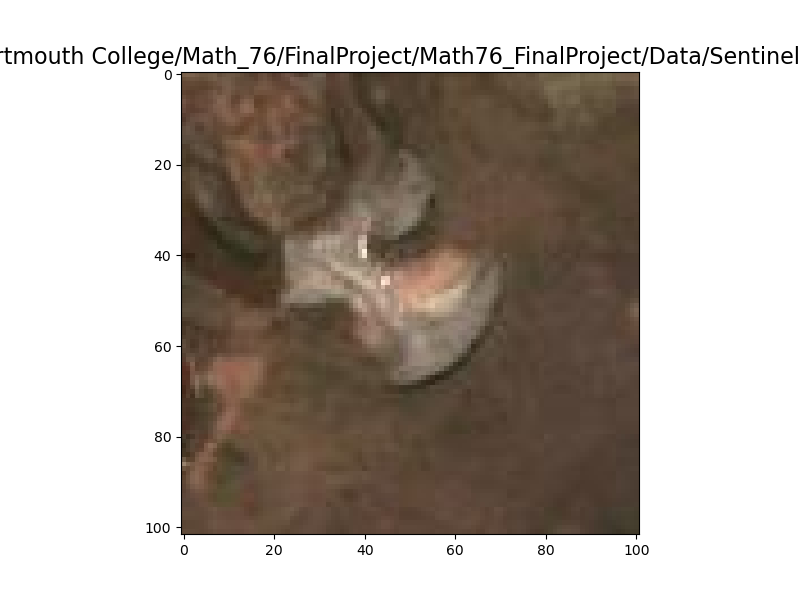

Labeling file 17/48: RGB_2024-06-15.jpg


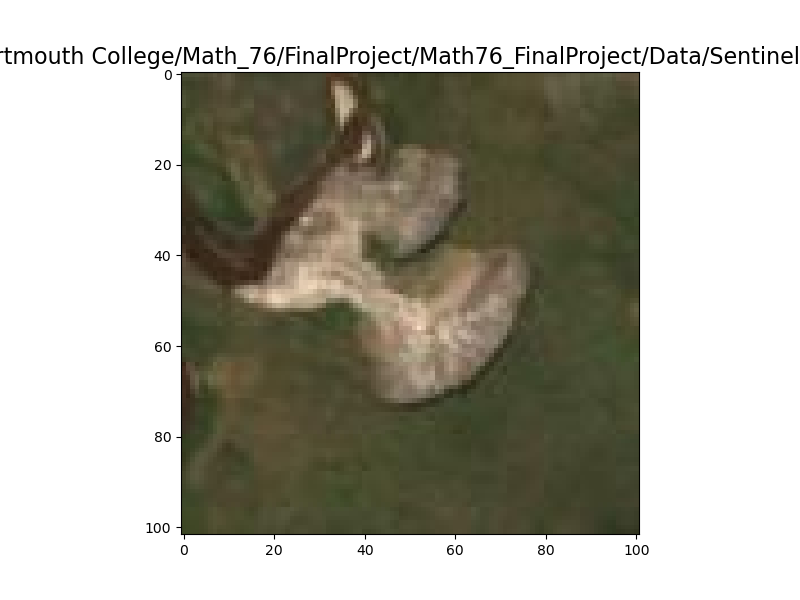

Labeling file 18/48: RGB_2019-06-07.jpg


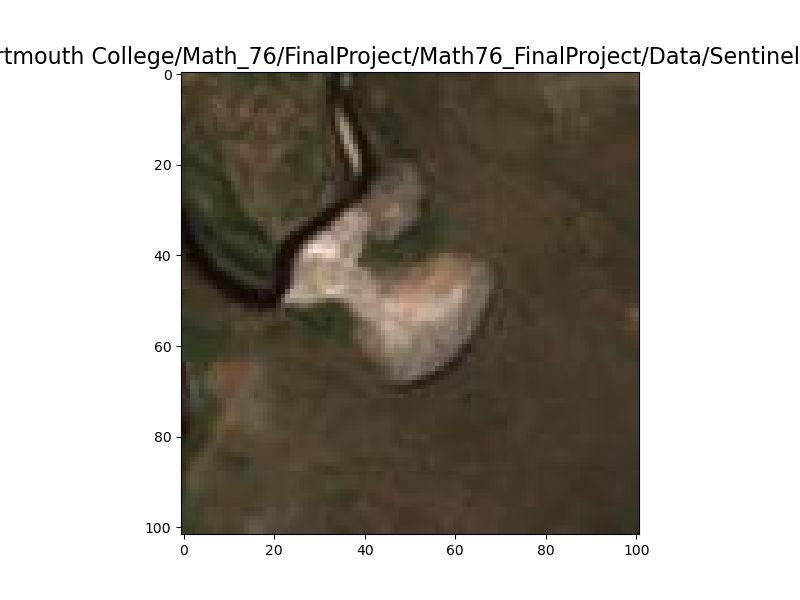

Labeling file 19/48: RGB_2022-06-28.jpg


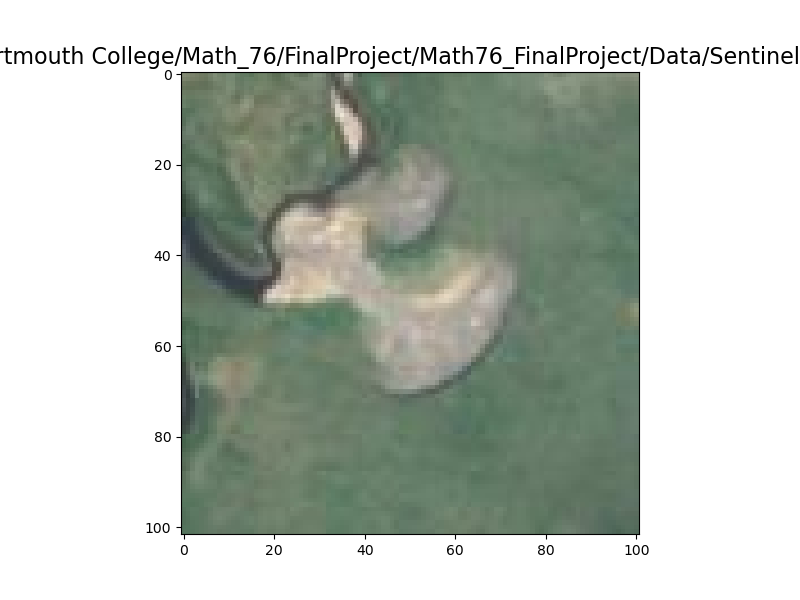

Labeling file 20/48: RGB_2021-06-23.jpg


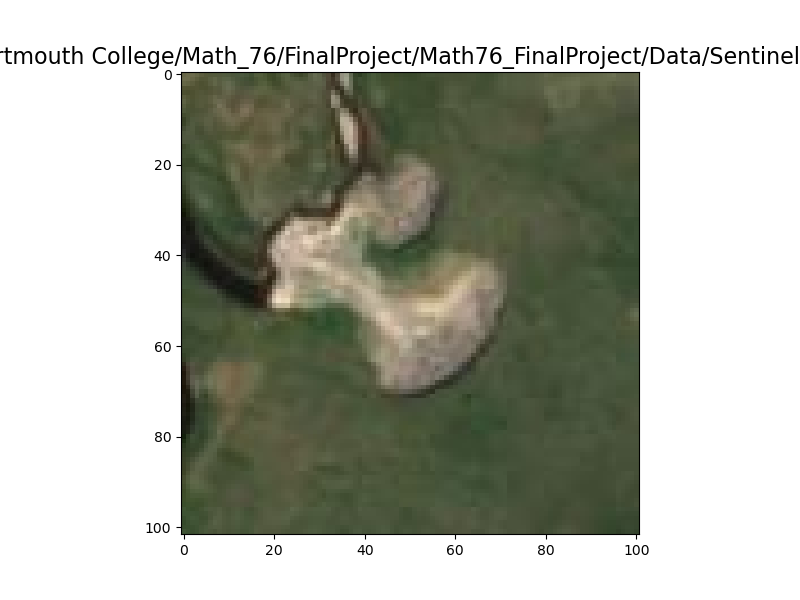

Labeling file 21/48: RGB_2019-09-03.jpg


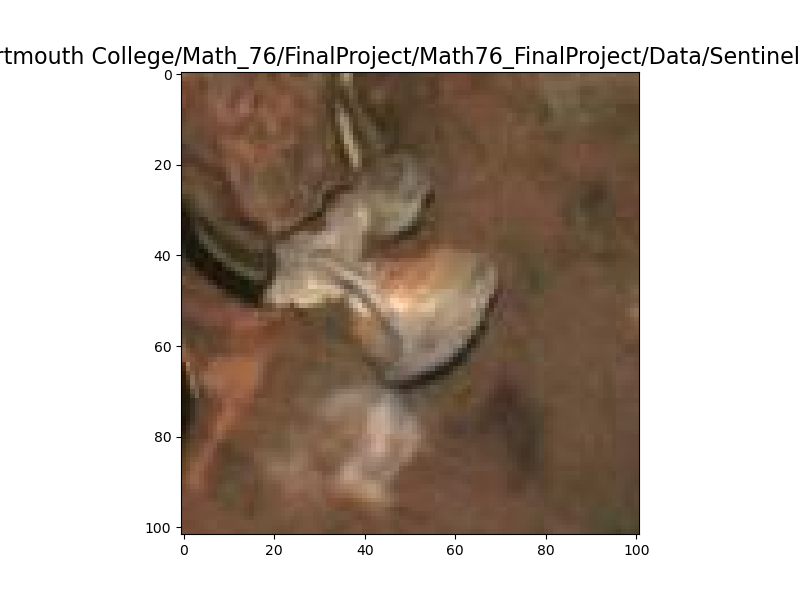

Labeling file 22/48: RGB_2022-07-01.jpg


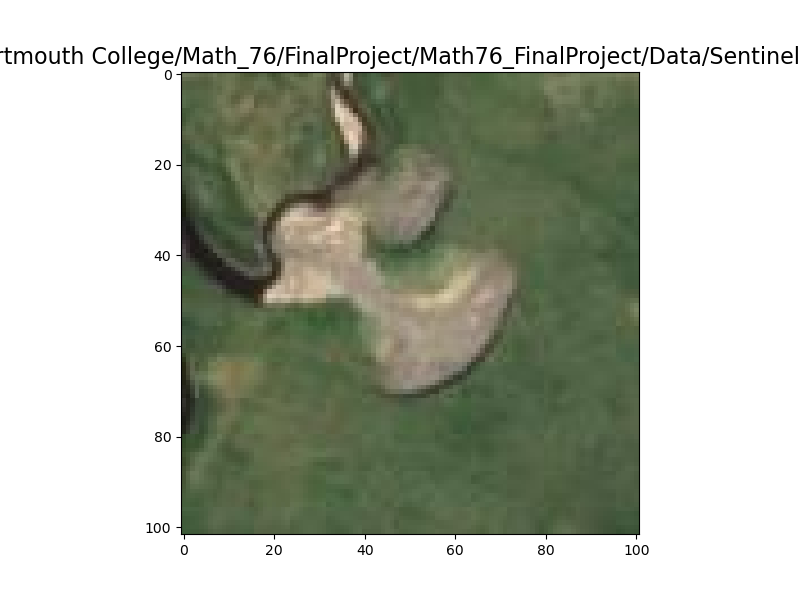

Labeling file 23/48: RGB_2021-08-03.jpg


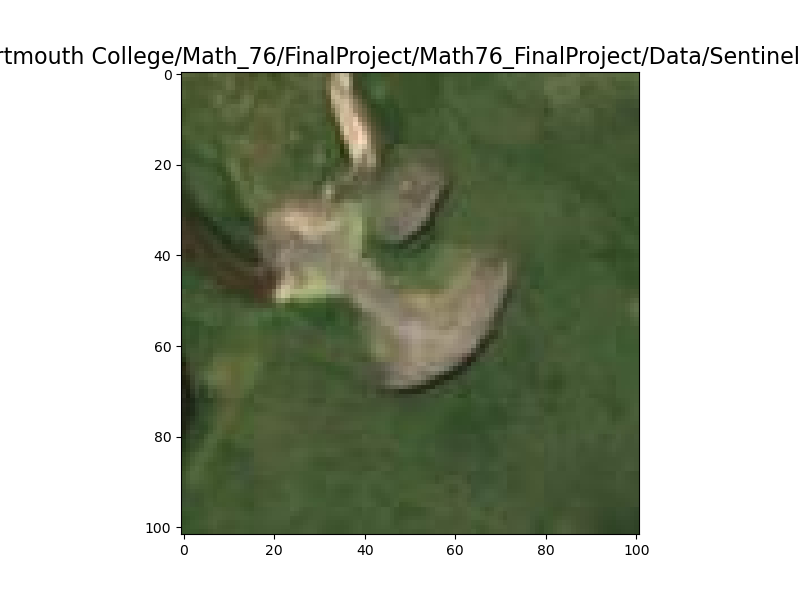

Labeling file 24/48: RGB_2024-06-23.jpg


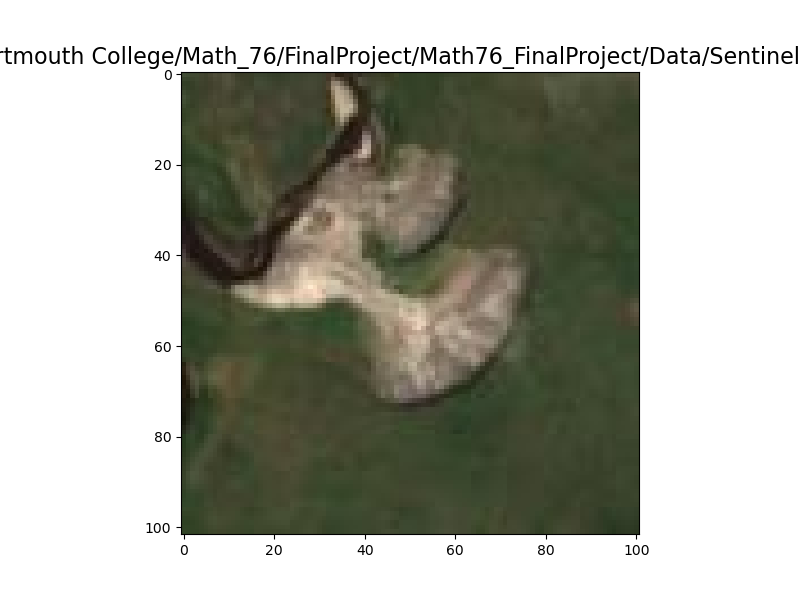

Labeling file 25/48: RGB_2020-09-06.jpg


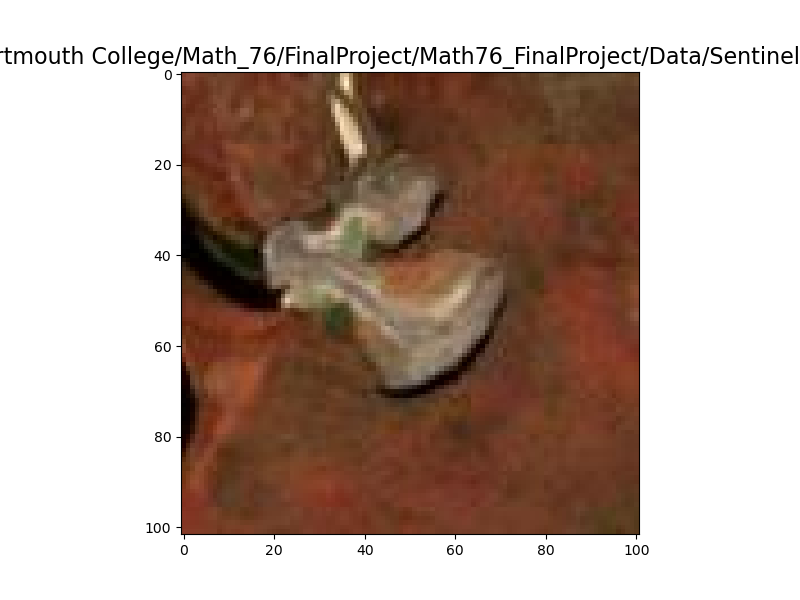

Labeling file 26/48: RGB_2020-06-14.jpg


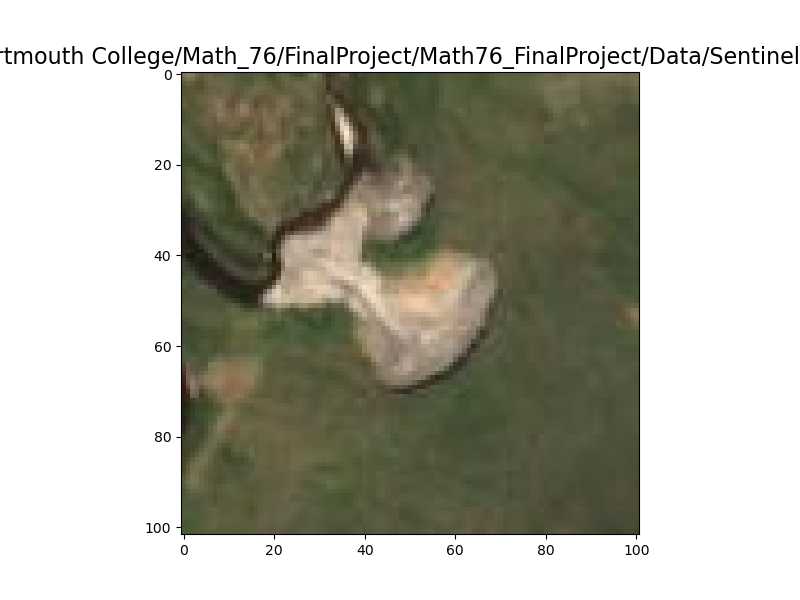

Labeling file 27/48: RGB_2019-09-20.jpg


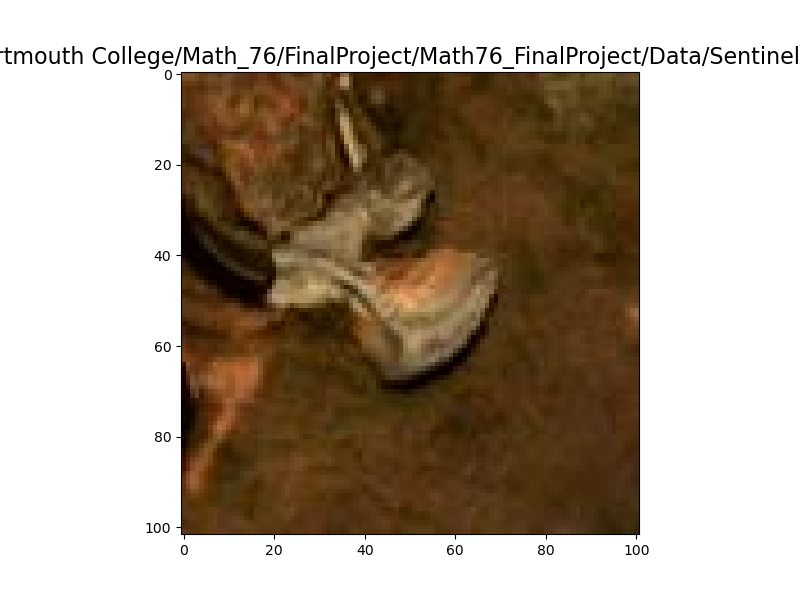

Labeling file 28/48: RGB_2020-08-28.jpg


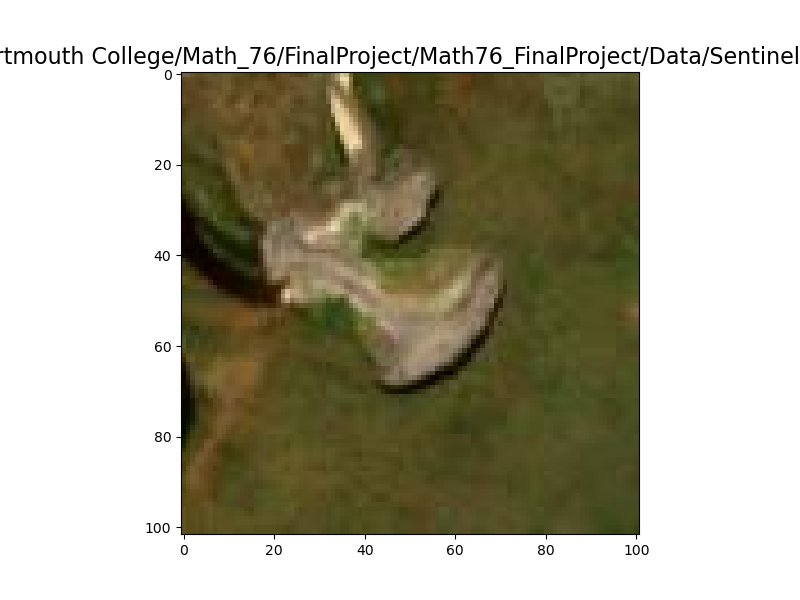

Labeling file 29/48: RGB_2021-06-14.jpg


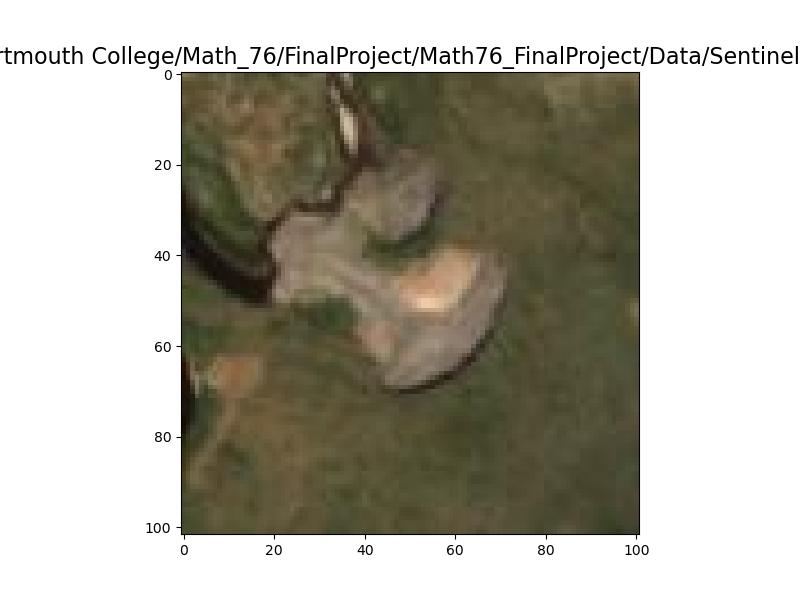

Labeling file 30/48: RGB_2024-08-06.jpg


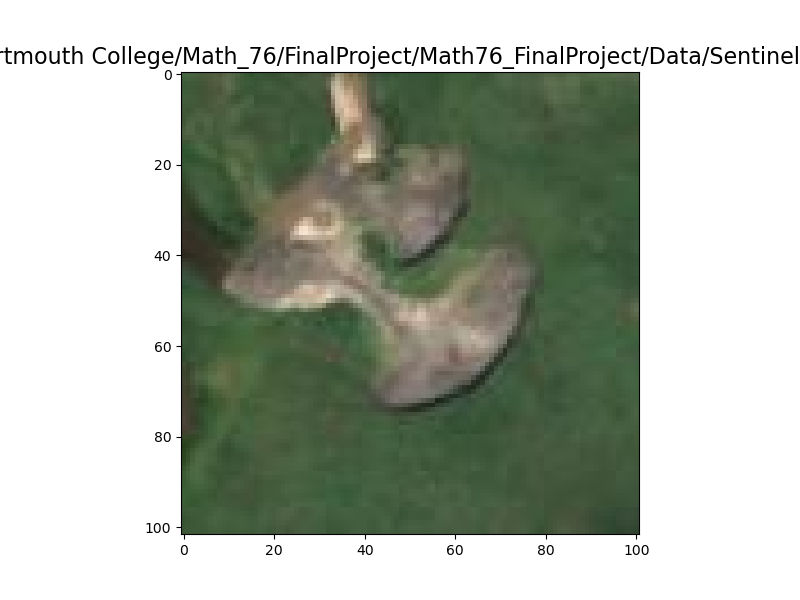

Labeling file 31/48: RGB_2021-07-16.jpg


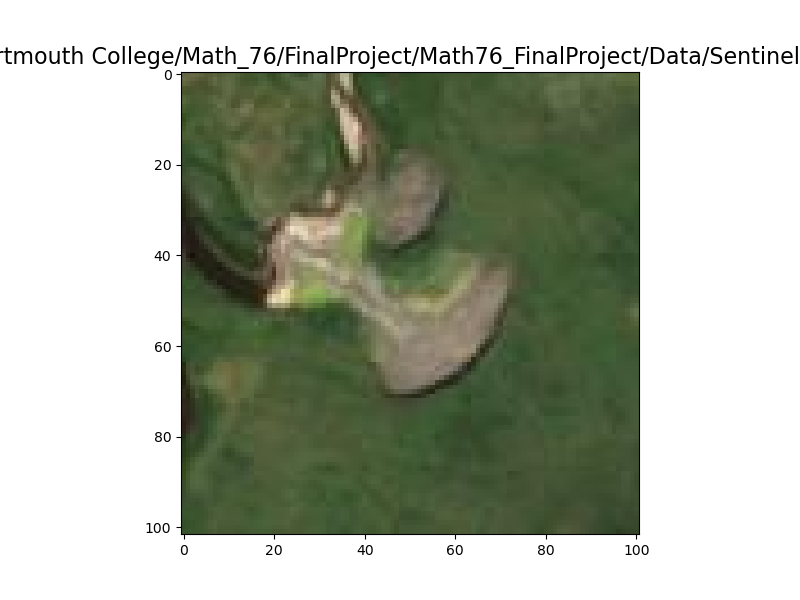

Labeling file 32/48: RGB_2021-06-19.jpg


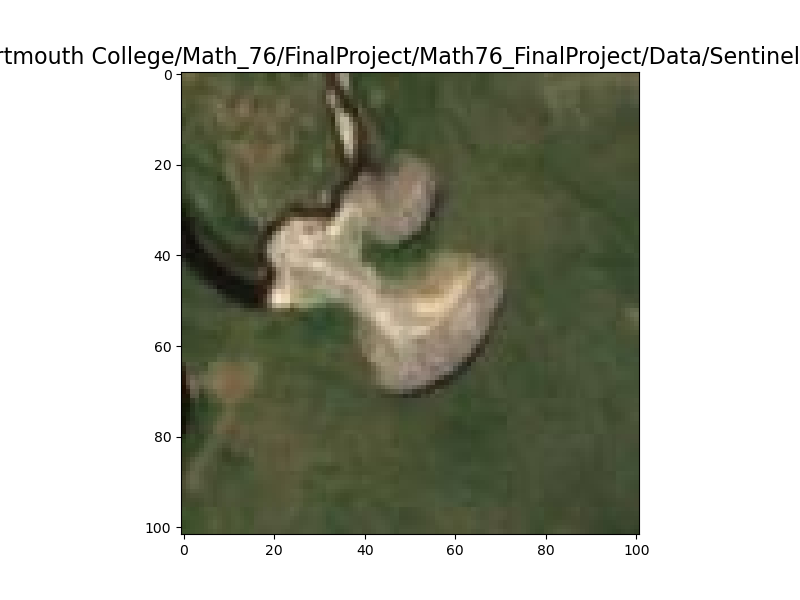

Labeling file 33/48: RGB_2024-07-23.jpg


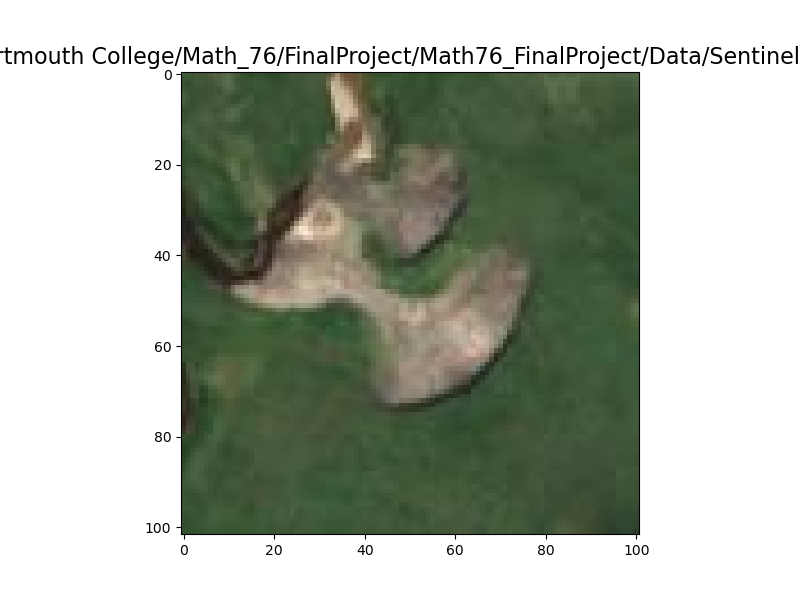

Labeling file 34/48: RGB_2021-09-07.jpg


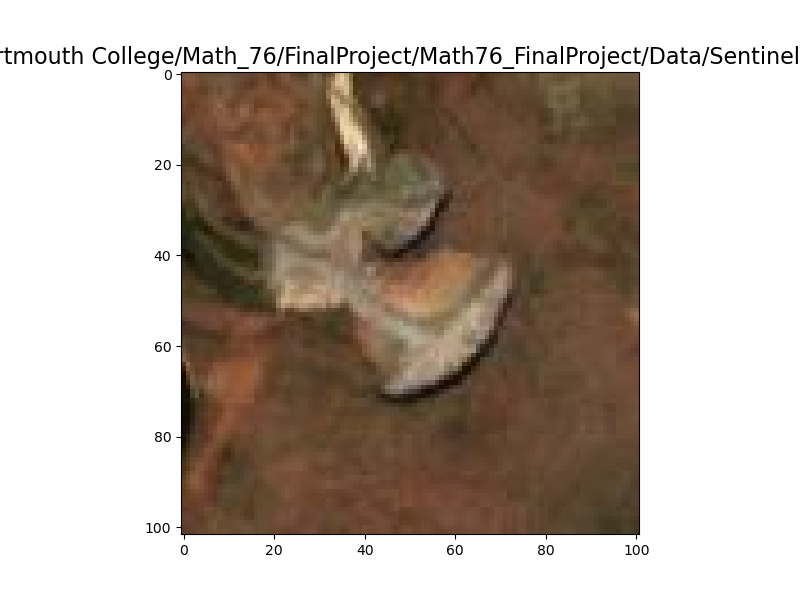

Labeling file 35/48: RGB_2019-09-07.jpg


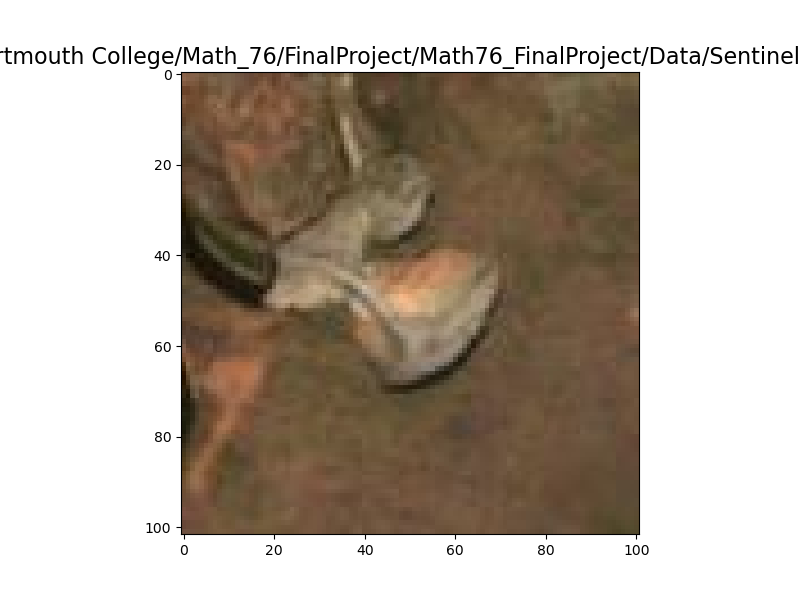

Labeling file 36/48: RGB_2024-06-05.jpg


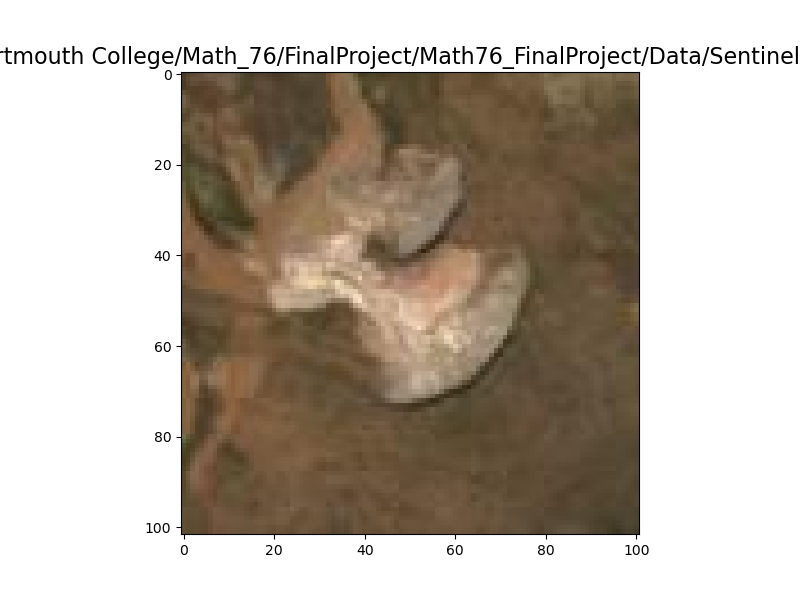

Labeling file 37/48: RGB_2020-07-31.jpg


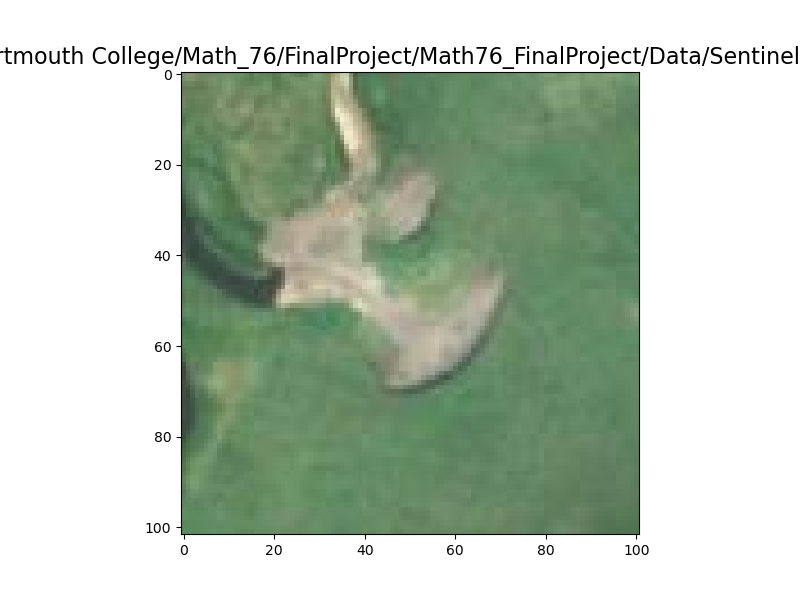

Labeling file 38/48: RGB_2020-08-18.jpg


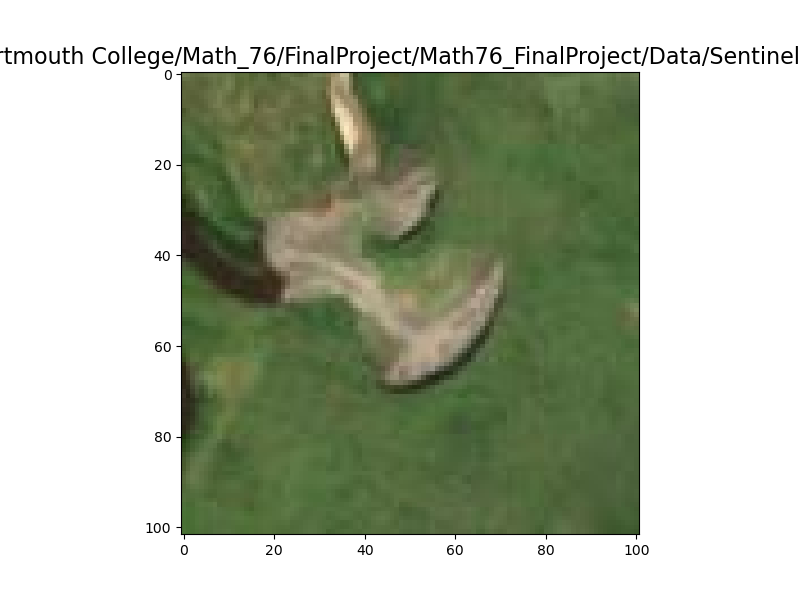

Labeling file 39/48: RGB_2022-08-12.jpg


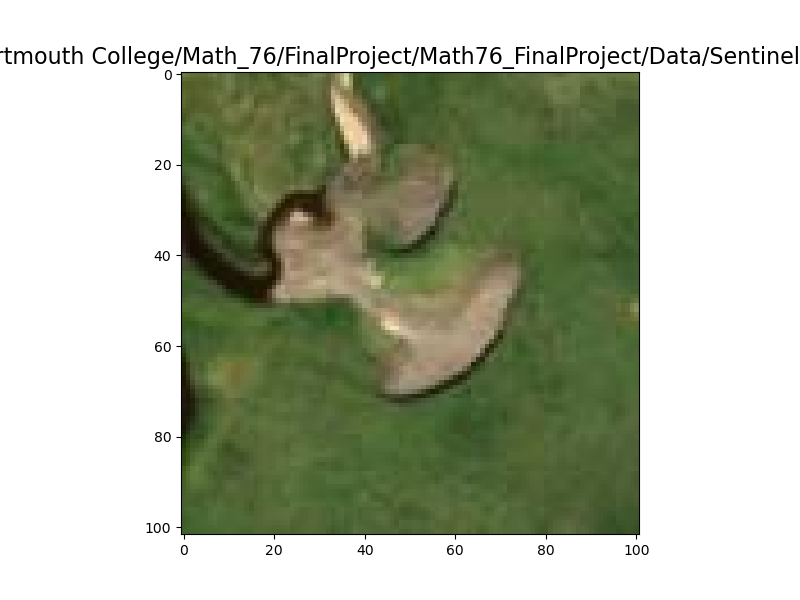

Labeling file 40/48: RGB_2021-09-02.jpg


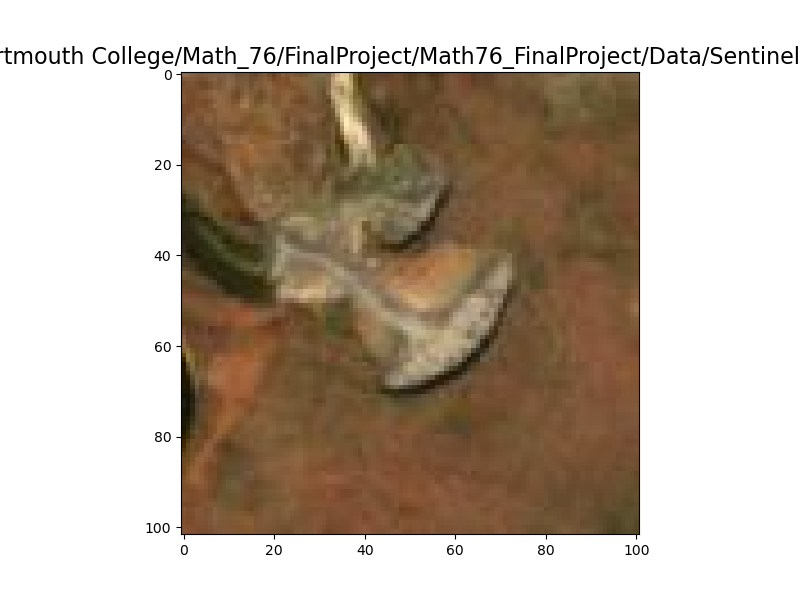

Labeling file 41/48: RGB_2020-06-29.jpg


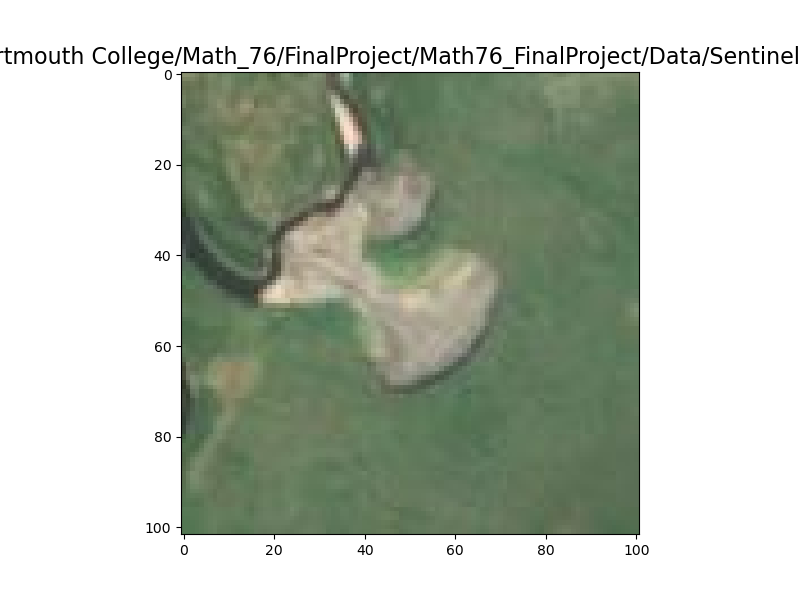

Labeling file 42/48: RGB_2020-07-11.jpg


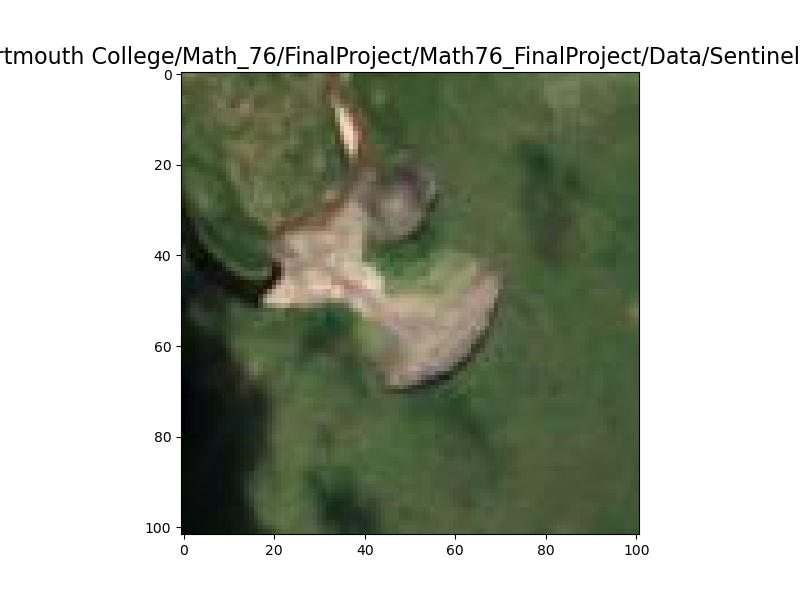

Labeling file 43/48: RGB_2021-07-23.jpg


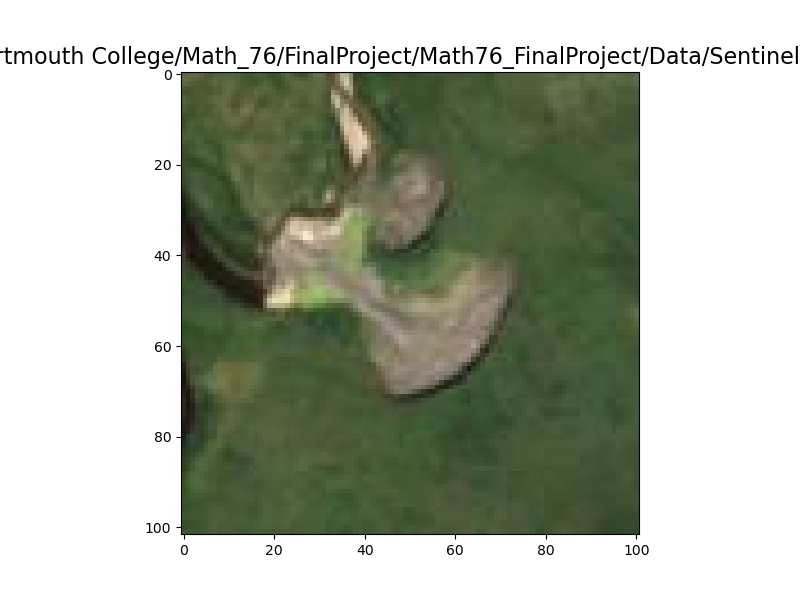

Labeling file 44/48: RGB_2019-07-27.jpg


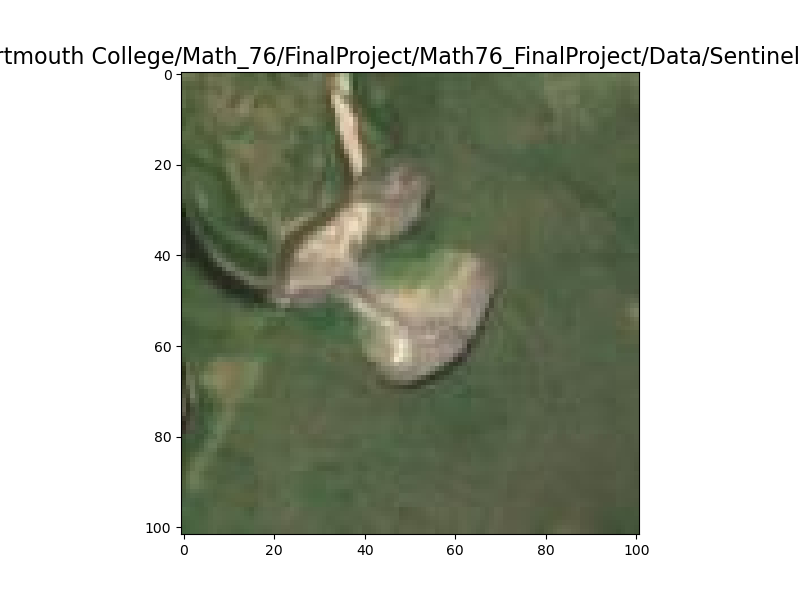

Labeling file 45/48: RGB_2019-07-25.jpg


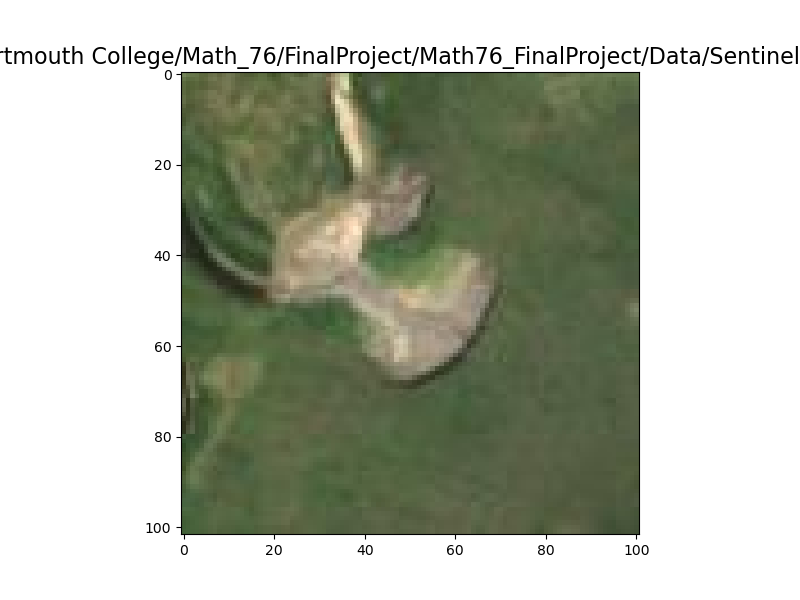

Labeling file 46/48: RGB_2022-08-05.jpg


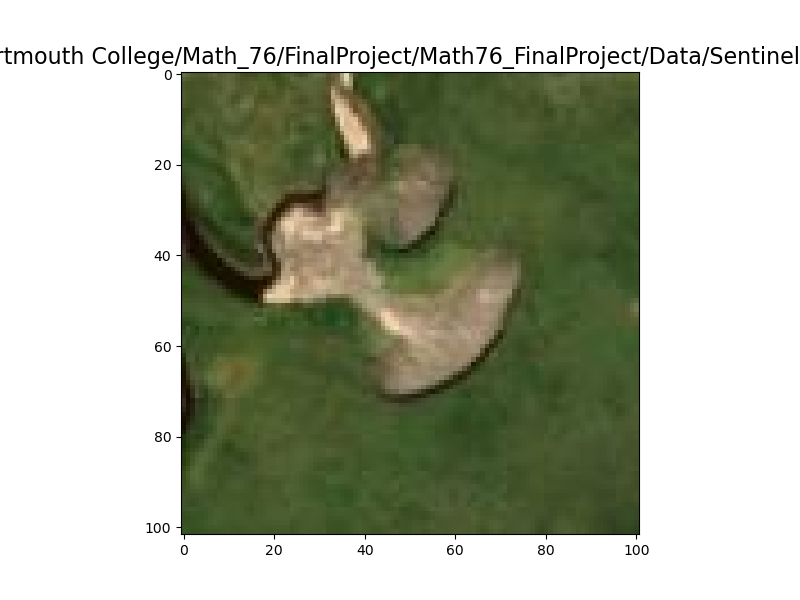

Labeling file 47/48: RGB_2023-09-17.jpg


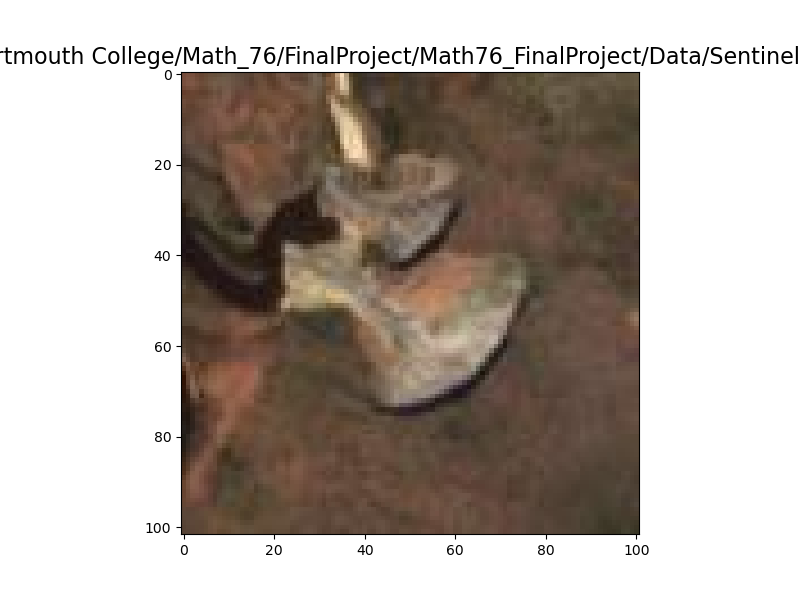

Labeling file 48/48: RGB_2022-06-21.jpg


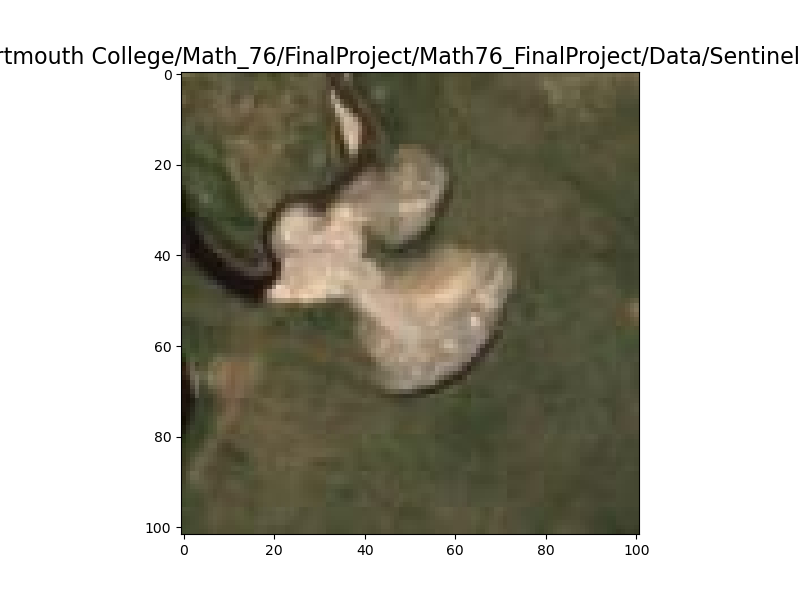

In [11]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
from scipy.interpolate import splprep, splev
import random  
import json    

def collect_points(img_path, df, output_dir, csv_path, IMAGE_TOTAL_AREA=1_000, DISPLAY=False, DEBUG=False):
    # widget backend for interactive plots
    %matplotlib widget
    points = []

    def onclick(event, points, ax):
        ix, iy = event.xdata, event.ydata
        if ix is not None and iy is not None:
            points.append((ix, iy))  # Save points as tuples
            ax.plot(ix, iy, 'ro')
            plt.draw()
            print(f"Point selected: ({ix}, {iy})")

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(img, aspect='equal')  # ensure the aspect ratio is equal to the image
    ax.set_aspect('equal', 'box') 
    
    # connect the click event to the plot
    cid = fig.canvas.mpl_connect('button_press_event', lambda event: onclick(event, points, ax))

    plt.title(img_path, fontsize=16)
    
    # show the plot
    plt.show()

    # create a separate button widget, positioned below the plot
    done_button = widgets.Button(description="Done")
    button_box = widgets.HBox([done_button])
    display(button_box)

    # define the button click event
    def ondone(b):
        nonlocal df
        # perform area calculations
        if len(points) > 2:
            if not np.array_equal(points[0], points[-1]):
                points.append(points[0])  # close the loop
    
            points_np = np.array(points)
            tck, u = splprep([points_np[:, 0], points_np[:, 1]], s=0, per=True)
            new_points = splev(np.linspace(0, 1, 1000), tck)
            spline_points = np.vstack(new_points).T.astype(np.int32)
    
            mask_black = np.zeros_like(img)
            cv2.fillPoly(mask_black, [spline_points], color=(255, 255, 255))
            selected_region_only = cv2.bitwise_and(img, mask_black)
    
            bounded_area = np.sum(mask_black[:, :, 0] == 255)
            total_area = img.shape[0] * img.shape[1]
            percentage_area = (bounded_area / total_area) * 100
            estimated_area = (IMAGE_TOTAL_AREA * percentage_area / 100)
    
            # highlight the generated spline border in red
            border_overlay_img = img.copy()
            cv2.polylines(border_overlay_img, [spline_points], isClosed=True, color=(255, 0, 0), thickness=1)
    
            # create a 1x2 figure with both the red border overlay and the selected region
            output_img_path = os.path.join(output_dir, os.path.basename(img_path).replace('.jpg', '_segmented.jpg'))
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
            # plot the red border overlay image
            axs[0].imshow(border_overlay_img)
            axs[0].set_title("Border Overlay", fontsize=16)
            axs[0].axis('off')
    
            # plot the selected region image
            axs[1].imshow(selected_region_only)
            axs[1].set_title("Selected Region Only", fontsize=16)
            axs[1].axis('off')
    
            # set the main title with the estimated area
            fig.suptitle(f"(Area: {estimated_area:.2f} Sq. Miles)", fontsize=12)
            plt.savefig(output_img_path)
            plt.close()

            # Save the points as a JSON string
            points_json = json.dumps(points)
            
            # check if the filename already exists in the dataframe
            if img_path in df['File Name'].values:
                # update the existing row
                df.loc[df['File Name'] == img_path, ['Estimated Area', 'Segmented Image Path', 'Clicked Points']] = [estimated_area, output_img_path, points_json]
            else:
                # add a new row
                new_row = pd.DataFrame({
                    'File Name': [img_path], 
                    'Estimated Area': [estimated_area],
                    'Segmented Image Path': [output_img_path],
                    'Clicked Points': [points_json]
                })

                df = pd.concat([df, new_row], ignore_index=True)

            # Save the dataframe by appending to the csv
            save_to_csv(df, csv_path)
            print(f"Data appended to {csv_path}")

        else:
            print("Not enough points selected to form a valid area.")

        fig.canvas.mpl_disconnect(cid)  # disconnect the click event
        plt.close(fig)  # close the plot window

        if DEBUG:
            print(df)

    # bind the button click event to the ondone function
    done_button.on_click(ondone)

    return df  # return the updated dataframe

def save_to_csv(df, csv_path):
    # Check if file exists
    if not os.path.isfile(csv_path):
        df.to_csv(csv_path, index=False)  # Save with header if file does not exist
    else:
        df.to_csv(csv_path, mode='a', header=False, index=False)  # Append without header if file exists

def load_and_label_images(directory_path, output_dir, csv_path='image_data.csv', IMAGE_TOTAL_AREA=1_000, DISPLAY=True, DEBUG=False):
    # load the dataframe from the csv if it exists, otherwise create a new one
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        df = pd.DataFrame(columns=['File Name', 'Estimated Area', 'Segmented Image Path', 'Clicked Points'])

    # ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # get all image files in the directory
    files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
    print(f"Found {len(files)} files in the directory.")

    # ask how many files to label
    num_files_to_label = int(input(f"How many files do you want to label? (Max {len(files)}): "))
    num_files_to_label = min(num_files_to_label, len(files))

    # randomly select the files if num_files_to_label is less than len(files)
    selected_files = random.sample(files, num_files_to_label)

    # loop through the selected files and label them
    for i, file in enumerate(selected_files):
        img_path = os.path.join(directory_path, file)
        print(f"Labeling file {i+1}/{num_files_to_label}: {file}")
        df = collect_points(img_path, df, output_dir, csv_path, IMAGE_TOTAL_AREA=IMAGE_TOTAL_AREA, DISPLAY=DISPLAY, DEBUG=DEBUG)

# example usage
directory_path = 'C:/Users/cmeri/OneDrive - Dartmouth College/Math_76/FinalProject/Math76_FinalProject/Data/Sentinel-s002/RGB'  # directory path
output_dir = 'C:/Users/cmeri/OneDrive - Dartmouth College/Math_76/FinalProject/Math76_FinalProject/Output'  # directory to save the segmented images
csv_path = 'Manual_Segmentation.csv'
load_and_label_images(directory_path, output_dir, csv_path=csv_path, IMAGE_TOTAL_AREA=1.0302, DISPLAY=True, DEBUG=False)


In [6]:
plt.close()